In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import numpy.ma as ma
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns

# import regridHelper

In [2]:
# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [4]:
# Load in Obs
data_dir = r'/home/disk/sipn/nicway/data/obs/'
fig_dir = r'/home/disk/sipn/nicway/python/ESIO/figures'
da_51 = xr.open_dataarray(os.path.join(data_dir, 'NSIDC_0051/sipn_nc/NSIDC_0051.nc'))
da_79 = xr.open_dataarray(os.path.join(data_dir, 'NSIDC_0079/sipn_nc/NSIDC_0079.nc'))
da_81 = xr.open_dataarray(os.path.join(data_dir, 'NSIDC_0081/sipn_nc/NSIDC_0081.nc'))

In [5]:
# Load in Model
ds_gfdl_flor = xr.open_dataset('/home/disk/sipn/nicway/data/model/nmme/GFDL_FLORB01/hist/stereo/GFDL_FLORB01_Stereo.nc')

In [6]:
da_81

<xarray.DataArray (time: 1141, y: 448, x: 304)>
[155395072 values with dtype=float64]
Coordinates:
  * x        (x) int64 -3850000 -3825000 -3800000 -3775000 -3750000 -3725000 ...
  * y        (y) int64 5850000 5825000 5800000 5775000 5750000 5725000 ...
  * time     (time) datetime64[ns] 2015-01-01 2015-01-02 2015-01-03 ...
    lat      (x, y) float64 ...
    lon      (x, y) float64 ...

In [7]:
ds_gfdl_flor

<xarray.Dataset>
Dimensions:      (ensemble: 12, fore_time_i: 12, init_time: 23, x: 304, y: 448)
Coordinates:
    lon          (x, y) float64 ...
    lat          (x, y) float64 ...
  * ensemble     (ensemble) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * init_time    (init_time) datetime64[ns] 2013-01-16T12:00:00 ...
  * fore_time_i  (fore_time_i) int64 0 1 2 3 4 5 6 7 8 9 10 11
    fore_time    (init_time, fore_time_i) datetime64[ns] ...
Dimensions without coordinates: x, y
Data variables:
    sic          (ensemble, init_time, fore_time_i, x, y) float64 ...

In [8]:
# Aggregate over domain
da_51_avg = da_51.sum(dim='x').sum(dim='y')*(25*25)/(10**6)
da_79_avg = da_79.sum(dim='x').sum(dim='y')*(25*25)/(10**6)
da_81_avg = da_81.sum(dim='x').sum(dim='y')*(25*25)/(10**6)
ds_gfdl_flor_avg = ds_gfdl_flor.sic.sum(dim='x').sum(dim='y')*(25*25)/(10**6)

In [9]:
def plot_model_ensm(ds=None, axin=None, labelin=None, color='grey'):
    labeled = False
    for e in ds.ensemble:
        for it in ds.init_time:
            if labeled:
                labelin = '_nolegend_'
            axin.plot(ds.fore_time.sel(init_time=it), 
                      ds.sel(ensemble=e).sel(init_time=it), label=labelin, color=color)
            labeled = True

/home/disk/sipn/nicway/anaconda3/envs/xesmf/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


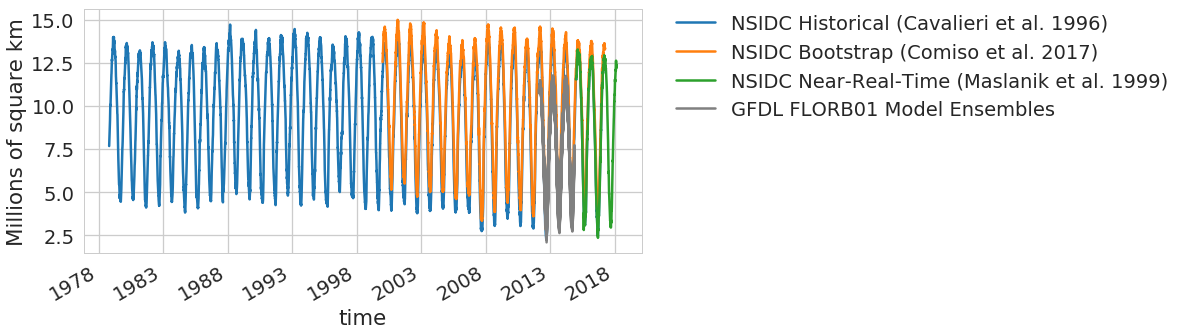

In [10]:
# Plot pan-Arctic sea ice extent
f, ax1 = plt.subplots(1,1)
f.set_size_inches(10, 5)
# Observations
da_51_avg.plot(ax=ax1, label='NSIDC Historical (Cavalieri et al. 1996)')
da_79_avg.plot(ax=ax1, label='NSIDC Bootstrap (Comiso et al. 2017)')
da_81_avg.plot(ax=ax1, label='NSIDC Near-Real-Time (Maslanik et al. 1999)')
plt.ylabel('Millions of square km')
# Models
plot_model_ensm(ds_gfdl_flor_avg, axin=ax1, labelin='GFDL FLORB01 Model Ensembles')
plt.legend(bbox_to_anchor=(1.03, 1.05))
f.savefig(os.path.join(fig_dir,'panArcticSIC.png'),bbox_inches='tight',dpi=200)

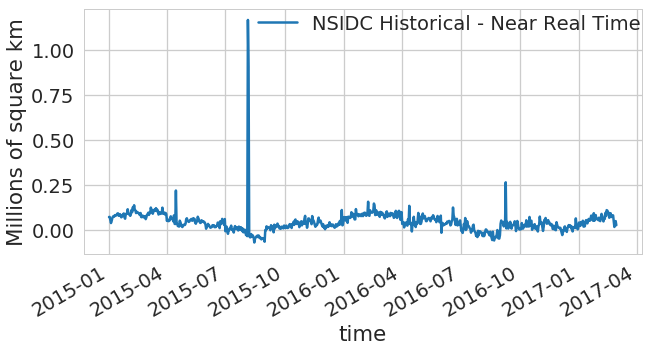

In [11]:
# Plot difference between NSIDC Historical and NRT data set
plt.figure(figsize=(10,5))
(da_51_avg-da_81_avg).plot(label='NSIDC Historical - Near Real Time')
plt.ylabel('Millions of square km')
plt.legend(bbox_to_anchor=(1.03, 1.05))

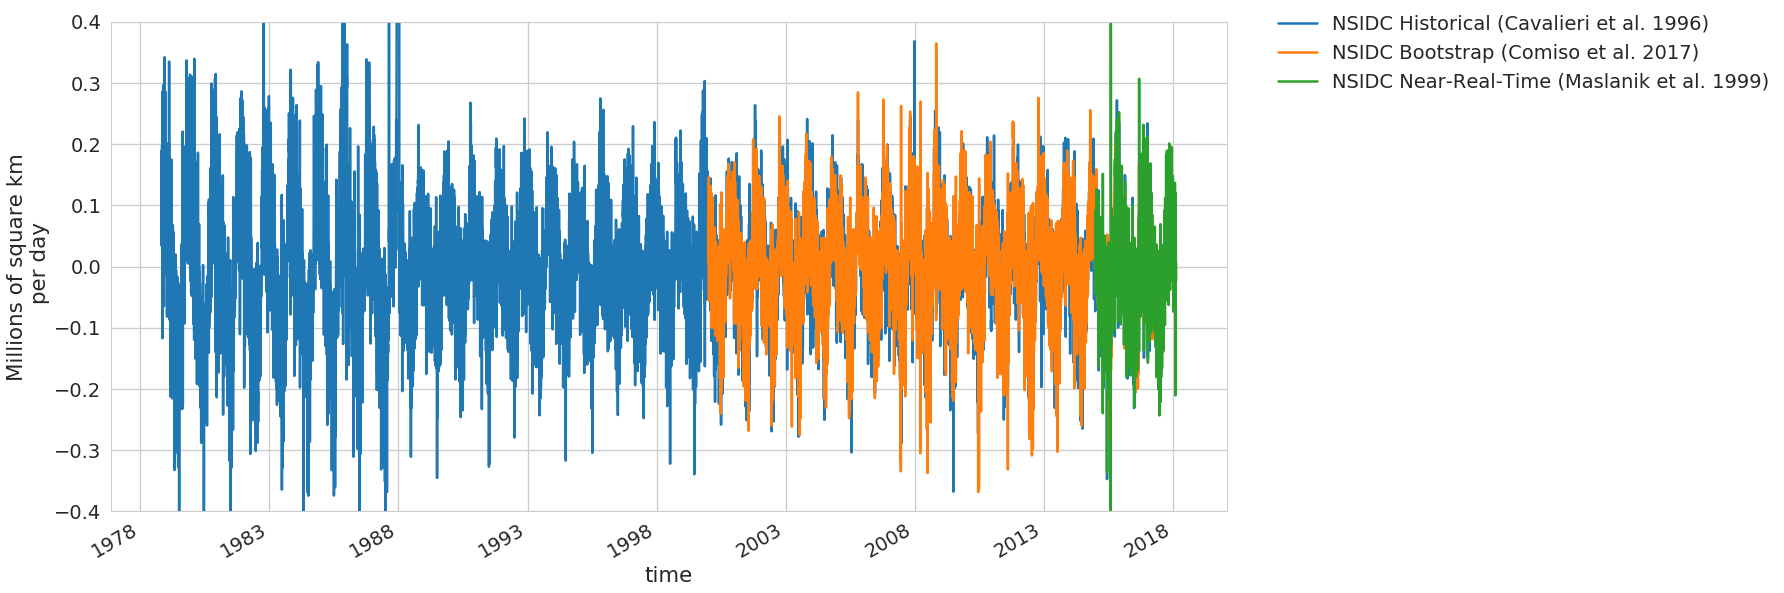

In [12]:
# Plot pan-Arctic sea ice extent RATE (daily)
f=plt.figure(figsize=(20,10))
da_51_avg.diff(dim='time').plot(label='NSIDC Historical (Cavalieri et al. 1996)')
da_79_avg.diff(dim='time').plot(label='NSIDC Bootstrap (Comiso et al. 2017)')
da_81_avg.diff(dim='time').plot(label='NSIDC Near-Real-Time (Maslanik et al. 1999)')
plt.ylabel('Millions of square km\n per day')
plt.legend(bbox_to_anchor=(1.03, 1.05))
plt.ylim([-0.4, 0.4])
f.savefig(os.path.join(fig_dir,'panArcticSIC.png'),bbox_inches='tight',dpi=200)

(-0.1, 0.1)

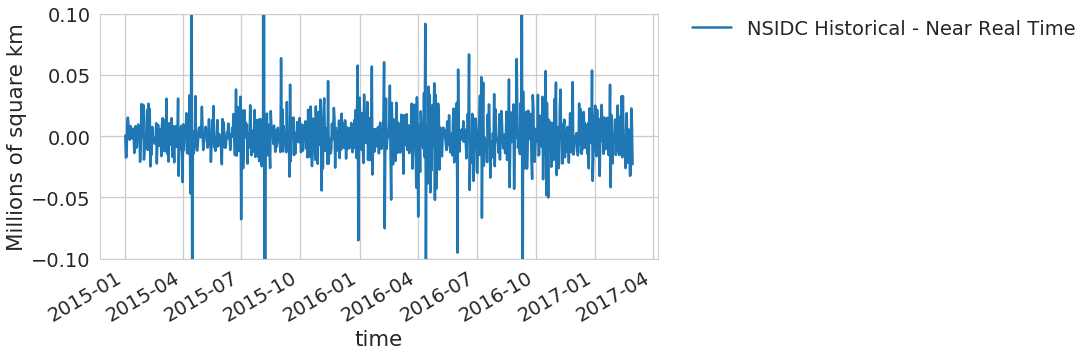

In [13]:
# Plot difference between NSIDC Historical and NRT data set RATES
plt.figure(figsize=(10,5))
(da_51_avg.diff(dim='time')-da_81_avg.diff(dim='time')).plot(label='NSIDC Historical - Near Real Time')
plt.ylabel('Millions of square km')
plt.legend(bbox_to_anchor=(1.03, 1.05))
plt.ylim([-0.1, 0.1])

In [14]:
# Set up plotting info
cmap_sic = matplotlib.colors.ListedColormap(sns.color_palette("Blues", 10))
cmap_sic.set_bad(color = 'lightgrey')
cmap_dif = matplotlib.colors.ListedColormap(sns.color_palette("RdBu", 10))
cmap_dif.set_bad(color = 'lightgrey')


In [15]:
# Plot coverage on a certain date
cdate = '2013-01-16'
c_sic = ds_gfdl_flor.isel(fore_time_i=0).load()
c_sic = c_sic.mean(dim='ensemble').sel(init_time=cdate, method='nearest').sic.squeeze()
c_sic

<xarray.DataArray 'sic' (x: 304, y: 448)>
array([[ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.]])
Coordinates:
    lon        (x, y) float64 168.3 168.4 168.5 168.7 168.8 168.9 169.0 ...
    lat        (x, y) float64 31.1 31.25 31.4 31.55 31.69 31.84 31.99 32.13 ...
    init_time  datetime64[ns] 2013-01-16T12:00:00
    fore_time  datetime64[ns] 2013-01-16T12:00:00
Dimensions without coordinates: x, y

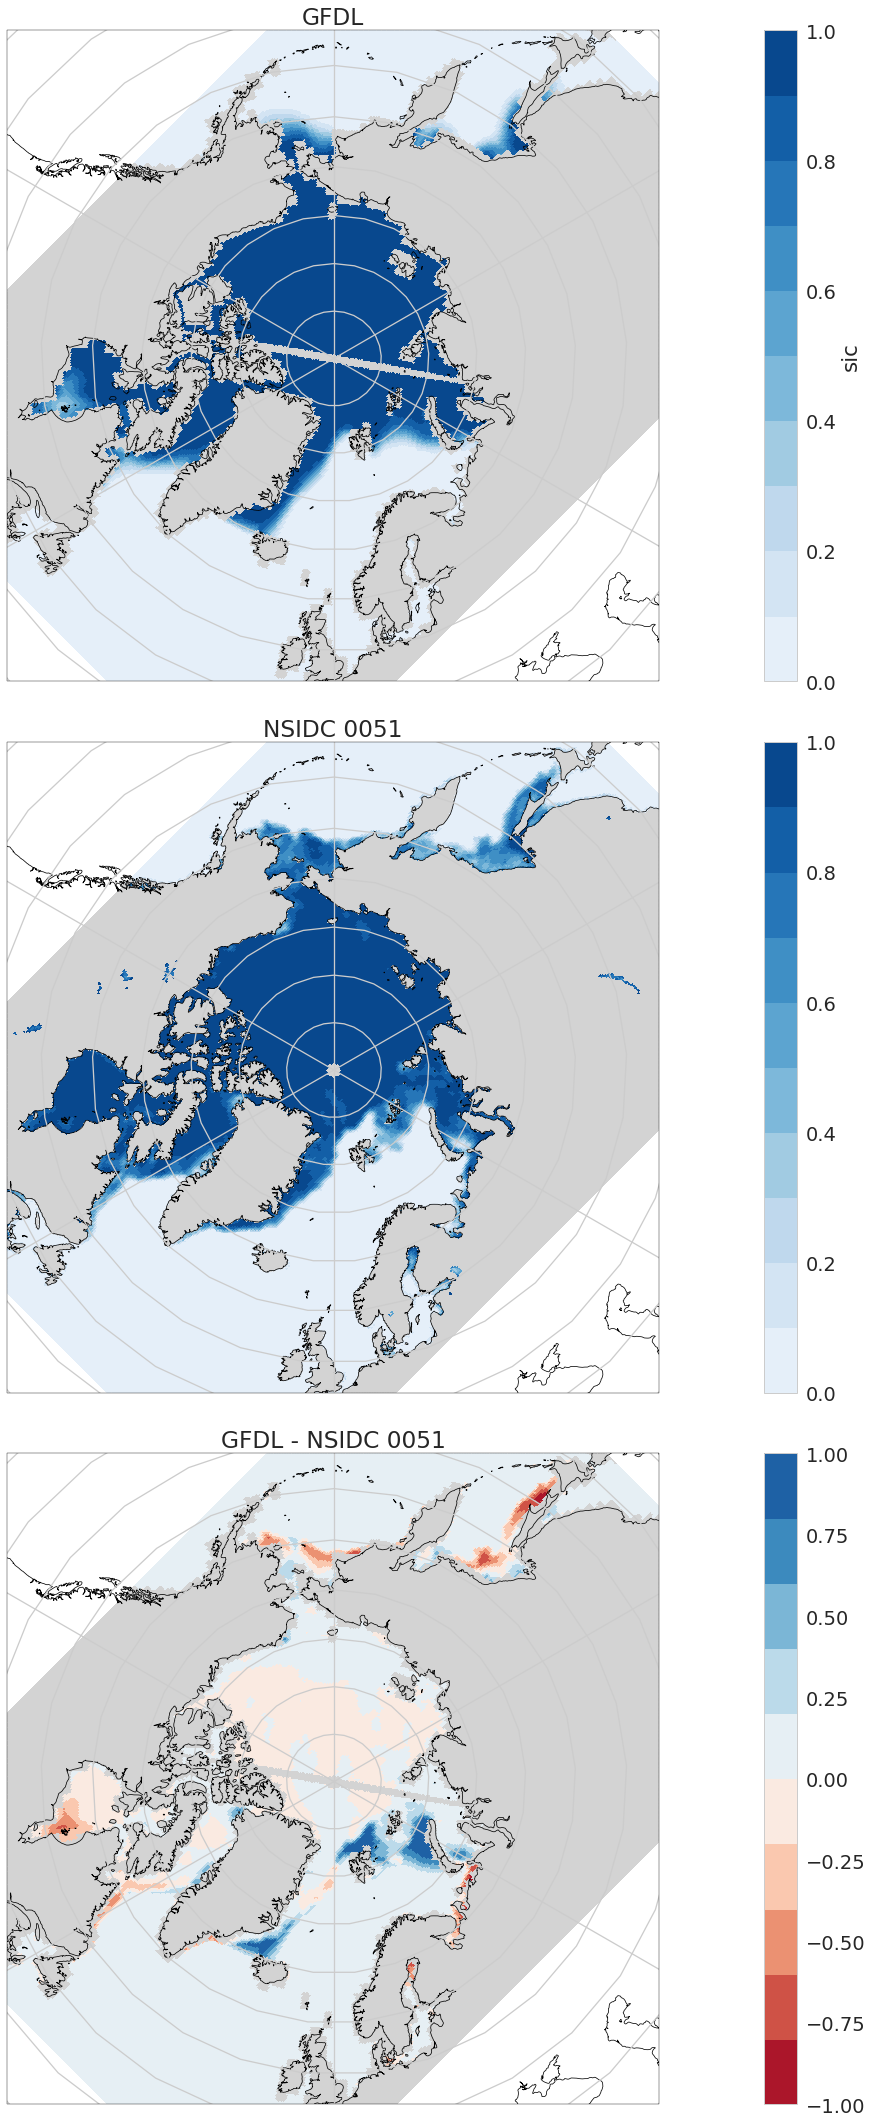

In [16]:
# Plot Obs and model SIC for date
f = plt.figure(figsize=(30,30));

# Model
ax1 = plt.subplot(3, 1, 1, projection=ccrs.NorthPolarStereo(central_longitude=0))
c_sic.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_sic,
                      vmin=0, vmax=1)
ax1.set_title('GFDL')
# Add coastlines and meridians/parallels 
ax1.coastlines(linewidth=0.75, color='black', resolution='50m')
ax1.gridlines(crs=ccrs.PlateCarree(), linestyle='-')
ax1.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())



# Obs NSIDC 0051
ax2 = plt.subplot(3, 1, 2, projection=ccrs.NorthPolarStereo(central_longitude=0))
da_51.sel(time=cdate).plot.pcolormesh(ax=ax2, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_sic,
                      vmin=0, vmax=1)
ax2.set_title('NSIDC 0051')
# Add coastlines and meridians/parallels 
ax2.coastlines(linewidth=0.75, color='black', resolution='50m')
ax2.gridlines(crs=ccrs.PlateCarree(), linestyle='-')
ax2.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())



# Model-Obs
ax3 = plt.subplot(3, 1, 3, projection=ccrs.NorthPolarStereo(central_longitude=0))
(c_sic - da_51.sel(time=cdate)).plot.pcolormesh(ax=ax3, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_dif,
                      vmin=-1, vmax=1)
ax3.set_title('GFDL - NSIDC 0051')
# Add coastlines and meridians/parallels 
ax3.coastlines(linewidth=0.75, color='black', resolution='50m')
ax3.gridlines(crs=ccrs.PlateCarree(), linestyle='-')
ax3.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())


plt.tight_layout()